# Chapter 4: Multilayer Perceptrons
#### Setion 4.4: Model Selection, Underfitting, and Overfitting

In [21]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
# Error in d2l train_epoch_ch3
import sys
sys.path.append('../d2l/')
from d2llocal import train_epoch_ch3


#### Generating the Dataset: Polinomial 3rd order

**$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$**


The noise term $\epsilon$ obeys a normal distribution
with a mean of 0 and a standard deviation of 0.1.

In [2]:
# Genero un polinomio de orden 3
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)


In [10]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

# Poly features son los terminos x^i/i! i = 0 ... 20 (max degree)
features[:2], poly_features[:2, :], labels[:2]
# I have the x's, the x^i/i! i = 0 ... 20 & the resulting y's

/media/simanato/48680A58680A44E2/workspace/pythonBox/anaconda3-4.3.1/envs/6.86x/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


(tensor([[-2.9317],
         [ 1.3992]]),
 tensor([[ 1.0000e+00, -2.9317e+00,  4.2975e+00, -4.1996e+00,  3.0780e+00,
          -1.8048e+00,  8.8185e-01, -3.6933e-01,  1.3535e-01, -4.4089e-02,
           1.2926e-02, -3.4449e-03,  8.4162e-04, -1.8980e-04,  3.9746e-05,
          -7.7682e-06,  1.4234e-06, -2.4547e-07,  3.9980e-08, -6.1689e-09],
         [ 1.0000e+00,  1.3992e+00,  9.7894e-01,  4.5659e-01,  1.5972e-01,
           4.4698e-02,  1.0424e-02,  2.0837e-03,  3.6444e-04,  5.6661e-05,
           7.9282e-06,  1.0085e-06,  1.1760e-07,  1.2657e-08,  1.2650e-09,
           1.1801e-10,  1.0320e-11,  8.4943e-13,  6.6031e-14,  4.8628e-15]]),
 tensor([-36.8644,   5.8662]))

#### Training and Testing the Model

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]


In [8]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())


#### Third-Order Polynomial Function Fitting (Normal)

weight: [[ 4.985634   1.2024411 -3.4062958  5.6173453]]


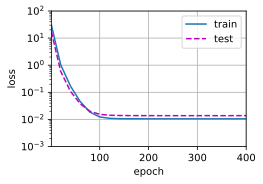

In [17]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
# Porque lo hace corrido, hace 0-99(train) & 100-199 (test)

# Yi = w1iX1i + w2iX2i + ..+ wniXni + bi
# Si en lugar de valores de feature vector le paso los valores 
# x^i/i! estoy reconstruyendo el polinomio
# En este caso de orden 3

n_polinomio = 3
train(poly_features[:n_train, :n_polinomio+1], poly_features[n_train:, :n_polinomio+1],
      labels[:n_train], labels[n_train:])


In [18]:
true_w

tensor([ 5.0000,  1.2000, -3.4000,  5.6000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000])

#### Linear Function Fitting (Underfitting)

weight: [[3.207474 4.759776]]


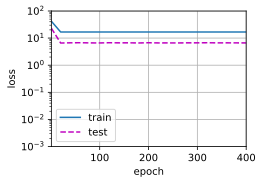

In [19]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
n_polinomio = 1
train(poly_features[:n_train, :n_polinomio+1], poly_features[n_train:, :n_polinomio+1],
      labels[:n_train], labels[n_train:])
# Modelo muy simple, no mejora la funcion de Loss, coincide tanto para el train como para el test

#### Higher-Order Polynomial Function Fitting (Overfitting)

weight: [[ 4.9694200e+00  1.2935354e+00 -3.3076327e+00  5.2639837e+00
  -2.6135623e-01  7.2904736e-01  2.7104390e-01 -4.8900757e-02
   2.6194803e-02 -1.2140130e-01  1.7230681e-01  7.7202352e-04
   5.0446555e-02 -1.0044457e-01 -8.9153901e-02 -1.0760437e-02
  -1.7060384e-01  6.8366759e-02  7.1807399e-02  1.6650999e-02]]


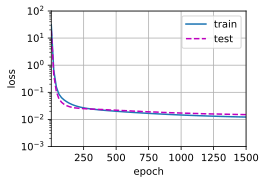

In [20]:
# Pick all the dimensions from the polynomial features
n_polinomio = len(poly_features)
print(n_polinomio)
train(poly_features[:n_train, :n_polinomio+1], poly_features[n_train:, :n_polinomio+1],
      labels[:n_train], labels[n_train:], num_epochs=1500)

# Mejora el train pero el test aumenta el error en Loss